## Introduction to the Data Set
### By: Sean TK Lim

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

The data file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day, as compiled by [Capital Bikeshare](https://www.capitalbikeshare.com/system-data).
 
A descriptions for the relevant columns:

 - instant - A unique sequential ID number for each row
 - dteday - The date of the rentals
 - season - The season in which the rentals occurred
 - yr - The year the rentals occurred
 - mnth - The month the rentals occurred
 - hr - The hour the rentals occurred
 - holiday - Whether or not the day was a holiday
 - weekday - The day of the week (as a number, 0 to 6)
 - workingday - Whether or not the day was a working day
 - weathersit - The weather (as a categorical variable)
 - temp - The temperature, on a 0-1 scale
 - atemp - The adjusted temperature
 - hum - The humidity, on a 0-1 scale
 - windspeed - The wind speed, on a 0-1 scale
 - casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
 - registered - The number of registered riders (people who had already signed up)
 - cnt - The total number of bike rentals (casual + registered)


In this project, we will attempt to predict the total number of bikes people rented in a given hour, or the cnt column.  To accomplish this, we will create a few different machine learning models and evaluate their predictive accuracy.

## Exploring the Data

In [1]:
import numpy as np
import pandas as pd

bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [2]:
bike_rentals.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [3]:
bike_rentals['instant'].unique()

array([    1,     2,     3, ..., 17377, 17378, 17379], dtype=int64)

The 'instant' column is merely a unique ID number assigned to each row and is irrelevant for modeling purposes.  We will remove it later on when we perform  feature selection.

In [4]:
bike_rentals.shape[0]

17379

In [5]:
bike_rentals.shape[1]

17

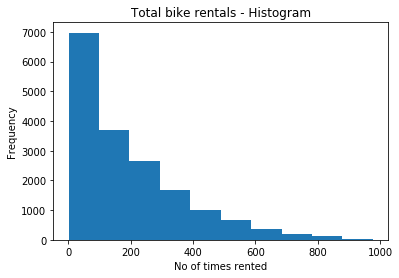

In [6]:
# Make a histogram of the cnt column of bike_rentals, and take a look at the distribution of total rentals.

%matplotlib inline
import matplotlib.pyplot as plt

# cnt - The total number of bike rentals (casual + registered)
plt.hist(bike_rentals['cnt'])
plt.title('Total bike rentals - Histogram')
plt.xlabel('No of times rented')
plt.ylabel('Frequency')
plt.show()

Using the corr method, we can rank each column in terms of correlation to 'cnt' (the bike rental count)

In [7]:
# Use the corr method on the bike_rentals dataframe to explore how each column is correlated with cnt.

bike_rentals.corr()['cnt'].sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

We find that 'hum' has the strongest negative correlation to 'cnt', while 'hr', 'atemp', and 'temp' show highest positve correlation.  We build a heatmap to visualise this.

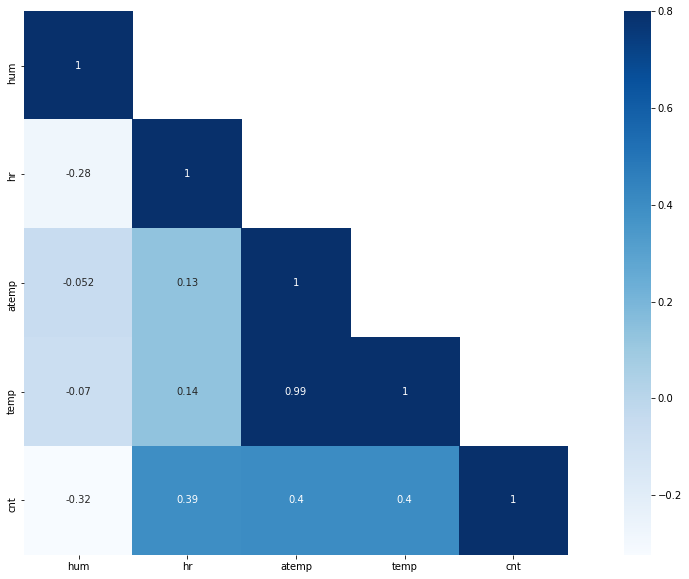

In [8]:
import seaborn as sns

# corrMatt = bike_rentals[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()

col = ['hum', 'hr', 'atemp', 'temp', 'cnt']
corrMatt = bike_rentals[col].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True, cmap="Blues")

## Calculating Additional Features


It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

Write a function called assign_label that takes in a numeric value for an hour, and returns:

- 1 if the hour is from 6 to 12 (morning)
- 2 if the hour is from 12 to 18 (afternoon)
- 3 if the hour is from 18 to 24 (evening)
- 4 if the hour is from 0 to 6 (night)


In [9]:
def assign_label(hour):
    if hour >= 0 and hour < 6:
        return 4
    elif hour >= 6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour < 24:
        return 3

# Use the apply method on series objects to apply the function to each item in the hr column
# Assign the result to the time_label column of bike_rentals
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [10]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## Splitting the Data Into Train and Test Sets
We will split the data into the train set and test set, with an 80/20 split, using a boolean mask.

In [11]:
# Train set = 80% sample of dataset
train = bike_rentals.sample(frac=.8)

# Test set - using Boolean mask for rows NOT in train set
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

##  Linear Regression
Next, we will apply linear regression to the data. The advantage of linear regression is its resistance to overfitting owing to its straightforward nature.  The disadvantage is that it can be prone to underfitting the data, resulting in a model that lacks explanatory power. Overall, this means that linear regression usually does not result in very high accuracy as compared to other models. 

### MSE_table_1 - All Columns
First, we will create a table to store the MSE values of the various models:

In [12]:
MSE_table_1 = pd.DataFrame(columns = ['Prediction Model', 'MSE'])

We will remove the casual and registered columns because the number of people who rent bikes in a given hour (cnt) is derived from them.  

In [13]:
train.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'time_label'],
      dtype='object')

In [14]:
from sklearn.linear_model import LinearRegression

# Create a list of predictor columns to use in training and predictions
# exclude the cnt, casual, dteday, and registered columns

predictors = list(train.columns)
predictors.remove('cnt')
predictors.remove('casual')
predictors.remove('registered')
predictors.remove('dteday')
predictors.remove('instant')

target = ['cnt']

lr = LinearRegression()
lr.fit(train[predictors], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [15]:
import numpy as np
predictions = lr.predict(test[predictors])

np.mean((predictions - test[target]) ** 2)

cnt    18744.458805
dtype: float64

In [16]:
# We can also import mean_squared_error to compute the MSE

from sklearn.metrics import mean_squared_error

# Actual vs prediction
mse = mean_squared_error(test[target], predictions)
mse = int(round(mse))

# Append to MSE table
new_row = ['LinearRegression', mse]
index_tracker = 0
MSE_table_1 = MSE_table_1.append(pd.DataFrame([new_row], columns=MSE_table_1.columns))
MSE_table_1

,Prediction Model,MSE
0,LinearRegression,18744


The mean squared error (MSE) for Linear Regression is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalised more heavily with MSE, which leads to a higher total error.

## Applying Decision Trees
We will next apply the decision tree algorithm, and compare its error with the error from linear regression, which will enable us to pick the right algorithm for this data set.

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we do not tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability - small changes in the input data can result in a very different output model.

We will import DecisionTreeRegressor from sklearn.tree.

In [17]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train['cnt'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [18]:
predictions = reg.predict(test[predictors])

# Manual calculation of MSE
# Actual vs prediction
np.mean((test['cnt'] - predictions) ** 2)

3032.329581270679

In [19]:
# We can also import mean_squared_error to compute the MSE

from sklearn.metrics import mean_squared_error

# Actual vs prediction
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))

# Append to MSE table
new_row = ['DecisionTree (leaf=5)', mse]
MSE_table_1 = MSE_table_1.append(pd.DataFrame([new_row], columns=MSE_table_1.columns))
MSE_table_1

,Prediction Model,MSE
0,LinearRegression,18744
0,DecisionTree (leaf=5),3032


We can also try changing the minimum number of samples per leaf to compare the effects on MSE:

In [20]:
#  Try changing to leaf=3

from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf=3)
reg.fit(train[predictors], train['cnt'])
predictions = reg.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))

# Append to MSE table
new_row = ['DecisionTree (leaf=3)', mse]
MSE_table_1 = MSE_table_1.append(pd.DataFrame([new_row], columns=MSE_table_1.columns))
MSE_table_1

,Prediction Model,MSE
0,LinearRegression,18744
0,DecisionTree (leaf=5),3032
0,DecisionTree (leaf=3),3269


In [21]:
#  Try changing to leaf=2

from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf=2)
reg.fit(train[predictors], train['cnt'])
predictions = reg.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))

# Append to MSE table
new_row = ['DecisionTree (leaf=2)', mse]
MSE_table_1 = MSE_table_1.append(pd.DataFrame([new_row], columns=MSE_table_1.columns))
MSE_table_1

,Prediction Model,MSE
0,LinearRegression,18744
0,DecisionTree (leaf=5),3032
0,DecisionTree (leaf=3),3269
0,DecisionTree (leaf=2),3529


#### Remarks

Overall, we observe that decision trees have much higher accuracy than simple Linear Regression. 

For decision trees, the minimum number of samples per leaf has a significant impact on the accuracy of the predictions, with leaf=5 having the lowest prediction MSE, i.e. the best model accuracy.

## Applying Random Forests
We shall now turn to the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression, and also less prone to overfitting than decision trees. Random forests can still be prone to overfitting, though, so it is important to tune parameters like maximum depth and minimum samples per leaf.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

reg = RandomForestRegressor(min_samples_leaf=5, n_estimators=10)
reg.fit(train[predictors], train['cnt'])

predictions = reg.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))

# Append to MSE table
new_row = ['RandomForest (leaf=5)', mse]
MSE_table_1 = MSE_table_1.append(pd.DataFrame([new_row], columns=MSE_table_1.columns))
MSE_table_1

,Prediction Model,MSE
0,LinearRegression,18744
0,DecisionTree (leaf=5),3032
0,DecisionTree (leaf=3),3269
0,DecisionTree (leaf=2),3529
0,RandomForest (leaf=5),2135


In [23]:
# Change to min_samples_leaf=3

reg = RandomForestRegressor(min_samples_leaf=3, n_estimators=10)
reg.fit(train[predictors], train['cnt'])

predictions = reg.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))

# Append to MSE table
new_row = ['RandomForest (leaf=3)', mse]
MSE_table_1 = MSE_table_1.append(pd.DataFrame([new_row], columns=MSE_table_1.columns))
MSE_table_1

,Prediction Model,MSE
0,LinearRegression,18744
0,DecisionTree (leaf=5),3032
0,DecisionTree (leaf=3),3269
0,DecisionTree (leaf=2),3529
0,RandomForest (leaf=5),2135
0,RandomForest (leaf=3),2101


In [24]:
# Change to min_samples_leaf=2

reg = RandomForestRegressor(min_samples_leaf=2, n_estimators=10)
reg.fit(train[predictors], train['cnt'])

predictions = reg.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))

# Append to MSE table
new_row = ['RandomForest (leaf=2)', mse]
MSE_table_1 = MSE_table_1.append(pd.DataFrame([new_row], columns=MSE_table_1.columns))
MSE_table_1

,Prediction Model,MSE
0,LinearRegression,18744
0,DecisionTree (leaf=5),3032
0,DecisionTree (leaf=3),3269
0,DecisionTree (leaf=2),3529
0,RandomForest (leaf=5),2135
0,RandomForest (leaf=3),2101
0,RandomForest (leaf=2),2102


#### Remarks

We can see that Random Forests provides much improved prediction accuracy vs decision trees.  Interestingly, reducing the leaf size for Random Forests actually helps improve model accuracy, whereas the opposite is true for Decision Trees.

## Selected Positively Related Columns
We can also compare the accuracy of the predictions, using only the positively related columns.  To select the positively related column, we can once again rank the columns in terms of correlation to the dependent variable 'cnt'.

We will need to create a new table to track the MSE scores:
### MSE_table_2 - Selected Positively Related Columns

In [25]:
MSE_table_2 = pd.DataFrame(columns = ['Prediction Model', 'MSE'])

For purposes of this exercise, we shall include only the columns with positive correlation > 0.2.  To do this we will write a custom function called corr_sorter:

In [26]:
# Column selection based on correlation to y-variable 'cnt'
description = 'Selected Postively Related Columns'

def corr_sorter(df):
    corr_rank = df.corr()['cnt'].sort_values()
    # Drop dependent variable and inappropriate columns
    corr_rank = corr_rank.drop('casual')
    corr_rank = corr_rank.drop('registered')
    corr_rank = corr_rank.drop('cnt')
    corr_rank = corr_rank.drop('instant')
    # Boolean mask
    corr_rank = corr_rank[corr_rank > 0.2]
    # Generate list of columns to be used
    table = pd.DataFrame(corr_rank)
    the_list = list(table.index)
    return the_list

print(description,':')
print(corr_sorter(bike_rentals))

Selected Postively Related Columns :
['yr', 'hr', 'atemp', 'temp']


Using the columns listed from our corr_sorter function, we will now run the models to see the impact on model accuracy:

In [27]:
# Create a list of predictor columns to use in training and predictions
predictors = corr_sorter(bike_rentals)
target = ['cnt']

# LinearRegression
lr = LinearRegression()
lr.fit(train[predictors], train[target])
predictions = lr.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))
# Append to MSE table
new_row = ['LinearRegression', mse]
MSE_table_2 = MSE_table_2.append(pd.DataFrame([new_row], columns=MSE_table_2.columns))

# DecisionTree
reg = DecisionTreeRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train['cnt'])
predictions = reg.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))
# Append to MSE table
new_row = ['DecisionTree', mse]
MSE_table_2 = MSE_table_2.append(pd.DataFrame([new_row], columns=MSE_table_2.columns))

# RandomForest
reg = RandomForestRegressor(min_samples_leaf=5, n_estimators=100)
reg.fit(train[predictors], train['cnt'])
predictions = reg.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))
# Append to MSE table
new_row = ['RandomForest', mse]
MSE_table_2 = MSE_table_2.append(pd.DataFrame([new_row], columns=MSE_table_2.columns))

# print(description, 'MSE:')
# print('LinearRegression', int(round(mse_08)))
# print('DecisionTree', int(round(mse_09)))
# print('RandomForest', int(round(mse_10)))

print('MSE Table 2 - Selected Positively Related Columns')
MSE_table_2

MSE Table 2 - Selected Positively Related Columns


,Prediction Model,MSE
0,LinearRegression,22925
0,DecisionTree,9897
0,RandomForest,9288


In [28]:
print('MSE Table 1 - All Columns')
MSE_table_1

MSE Table 1 - All Columns


,Prediction Model,MSE
0,LinearRegression,18744
0,DecisionTree (leaf=5),3032
0,DecisionTree (leaf=3),3269
0,DecisionTree (leaf=2),3529
0,RandomForest (leaf=5),2135
0,RandomForest (leaf=3),2101
0,RandomForest (leaf=2),2102


Interestingly, if we only include the positively correlated columns with correlation > 0.2, the accuracy of the predictions actually gets much worse compared to using all of the columns, especially for DecisionTree and RandomForest.

Our findings here suggest that DecisionTree and RandomForest predictions fare better with the inclusion of more features, even those with lower correlation scores.



## All Postively Related Columns


In [29]:
# Column selection based on correlation to y-variable 'cnt'
description = 'All Postively Related Columns'

def corr_sorter(df):
    corr_rank = df.corr()['cnt'].sort_values()
    # Drop dependent variable and inappropriate columns
    corr_rank = corr_rank.drop('casual')
    corr_rank = corr_rank.drop('registered')
    corr_rank = corr_rank.drop('cnt')
    corr_rank = corr_rank.drop('instant')
    # Boolean mask
    corr_rank = corr_rank[corr_rank > 0]
    # Generate list of columns to be used
    table = pd.DataFrame(corr_rank)
    the_list = list(table.index)
    return the_list

print(description,':')
print(corr_sorter(bike_rentals))

All Postively Related Columns :
['weekday', 'workingday', 'windspeed', 'mnth', 'season', 'yr', 'hr', 'atemp', 'temp']


### MSE_table_3 - All Positively Related Columns

In [30]:
# Create MSE Table - All Postively Related Columns
MSE_table_3 = pd.DataFrame(columns = ['Prediction Model', 'MSE'])

Apply machine learning models:

In [31]:
# Create a list of predictor columns to use in training and predictions
predictors = corr_sorter(bike_rentals)
target = ['cnt']

# LinearRegression
lr = LinearRegression()
lr.fit(train[predictors], train[target])
predictions = lr.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))
# Append to MSE table
new_row = ['LinearRegression', mse]
MSE_table_3 = MSE_table_3.append(pd.DataFrame([new_row], columns=MSE_table_3.columns))

# DecisionTree
reg = DecisionTreeRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train['cnt'])
predictions = reg.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))
# Append to MSE table
new_row = ['DecisionTree', mse]
MSE_table_3 = MSE_table_3.append(pd.DataFrame([new_row], columns=MSE_table_3.columns))

# RandomForest
reg = RandomForestRegressor(min_samples_leaf=5, n_estimators=100)
reg.fit(train[predictors], train['cnt'])
predictions = reg.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))
# Append to MSE table
new_row = ['RandomForest', mse]
MSE_table_3 = MSE_table_3.append(pd.DataFrame([new_row], columns=MSE_table_3.columns))

print('MSE Table 3 - All Positively Related Columns')
MSE_table_3

MSE Table 3 - All Positively Related Columns


,Prediction Model,MSE
0,LinearRegression,22511
0,DecisionTree,3256
0,RandomForest,2516


In [32]:
print('MSE Table 2 - Selected Positively Related Columns')
MSE_table_2

MSE Table 2 - Selected Positively Related Columns


,Prediction Model,MSE
0,LinearRegression,22925
0,DecisionTree,9897
0,RandomForest,9288


We find that including All Positively Related Columns does significantly improve the model accuracy for DecisionTree and RandomForest, as compared to just using Selected Positively Related Columns.  Next, we shall include only negatively correlated features to see the impact on model accuracy.

## Negatively Related Columns
Finally, we can test the accuracy of the machine learning model predictions by including only the negatively related columns, using our corr_sorter() function.

### MSE_table_4 - All Negatively Related Columns

In [33]:
# Create MSE Table - All Negatively Related Columns
MSE_table_4 = pd.DataFrame(columns = ['Prediction Model', 'MSE'])

Apply machine learning models:

In [34]:
# Column selection based on correlation to y-variable 'cnt'
description = 'All Negatively Related Columns'

def corr_sorter(df):
    corr_rank = df.corr()['cnt'].sort_values()
    # Drop dependent variable and inappropriate columns
    corr_rank = corr_rank.drop('casual')
    corr_rank = corr_rank.drop('registered')
    corr_rank = corr_rank.drop('cnt')
    corr_rank = corr_rank.drop('instant')
    # Boolean mask
    corr_rank = corr_rank[corr_rank < 0]
    # Generate list of columns to be used
    table = pd.DataFrame(corr_rank)
    the_list = list(table.index)
    return the_list

print(description,':')
print(corr_sorter(bike_rentals))

All Negatively Related Columns :
['time_label', 'hum', 'weathersit', 'holiday']


In [35]:
# Create a list of predictor columns to use in training and predictions
predictors = corr_sorter(bike_rentals)
target = ['cnt']

# LinearRegression
model_name = 'LinearRegression'
lr = LinearRegression()
lr.fit(train[predictors], train[target])
predictions = lr.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))
# Append to MSE table
new_row = [model_name, mse]
MSE_table_4 = MSE_table_4.append(pd.DataFrame([new_row], columns=MSE_table_4.columns))

# DecisionTree
model_name = 'DecisionTree'
reg = DecisionTreeRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train['cnt'])
predictions = reg.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))
# Append to MSE table
new_row = [model_name, mse]
MSE_table_4 = MSE_table_4.append(pd.DataFrame([new_row], columns=MSE_table_4.columns))

# RandomForest
model_name = 'RandomForest'
reg = RandomForestRegressor(min_samples_leaf=5, n_estimators=100)
reg.fit(train[predictors], train['cnt'])
predictions = reg.predict(test[predictors])
mse = mean_squared_error(test['cnt'], predictions)
mse = int(round(mse))
# Append to MSE table
new_row = [model_name, mse]
MSE_table_4 = MSE_table_4.append(pd.DataFrame([new_row], columns=MSE_table_4.columns))

MSE_table_4

,Prediction Model,MSE
0,LinearRegression,27628
0,DecisionTree,22718
0,RandomForest,22595


Unsurprisingly, the model accuracy becomes significantly worse when using only the negatively correlated features.

##  Summary & Conclusion

We explored the data set and identified certain features to remove, while focusing on others that show a higher degree of correlation to the dependent variable.

We then split the data into the train and test sets, using an 80/20 split, and applied the following machine learning models from the scikit-learn library:
- Linear Regression
- Decision Tree
- Random Forest

When using Mean Squared Error (MSE) as the benchmark for model accuracy, Decision Tree and Random Forest offer marked improvement over Linear Regression, with Random Forest offering the best level of accuracy.

We started off using all the columns in the dataset (except for the dependent variable 'cnt', or count of bike rides, and the 'instant' column.

In [36]:
# All Columns
MSE_table_1

,Prediction Model,MSE
0,LinearRegression,18744
0,DecisionTree (leaf=5),3032
0,DecisionTree (leaf=3),3269
0,DecisionTree (leaf=2),3529
0,RandomForest (leaf=5),2135
0,RandomForest (leaf=3),2101
0,RandomForest (leaf=2),2102


Next, we restricted to feature columns to only columns with more than 20% positive correlation to 'cnt', and found that model accuracy for DecisionTree and RandomForest greatly suffered:

In [37]:
# Selected Positively Related Columns
MSE_table_2

,Prediction Model,MSE
0,LinearRegression,22925
0,DecisionTree,9897
0,RandomForest,9288


We then move on to include all columns with postive correlation to 'cnt'.  Unsurprisingly, with the inclusion of more data, overall model accuracy showed marked improvement:

In [38]:
# All Positively Related Columns
MSE_table_3

,Prediction Model,MSE
0,LinearRegression,22511
0,DecisionTree,3256
0,RandomForest,2516


Out of interest, we tried computing model MSE purely for the columns that were negatively correlated to 'cnt'.  We found that this yielded the worst set of results in terms of model accuracy:

In [39]:
# All Negatively Related Columns
MSE_table_4

,Prediction Model,MSE
0,LinearRegression,27628
0,DecisionTree,22718
0,RandomForest,22595


In conclusion:
- We find that for the same set of data, RandomForest has the greatest accruacy, followed by DecisionTree.  
- Our earlier intuition that LinearRegression would not be a very accurate model was indeed proven correct.
- For RandomForest and DecisionTree, including all the feature columns resulted in the best model prediction accuracy.  In other words, more data does appear to be better.